# 1. Canny Edge Detector

In [1]:
from utils import *


In [2]:
image = mp_image.imread(os.path.join(img_src,'einstein2.png'))
image = image[:,:,0]

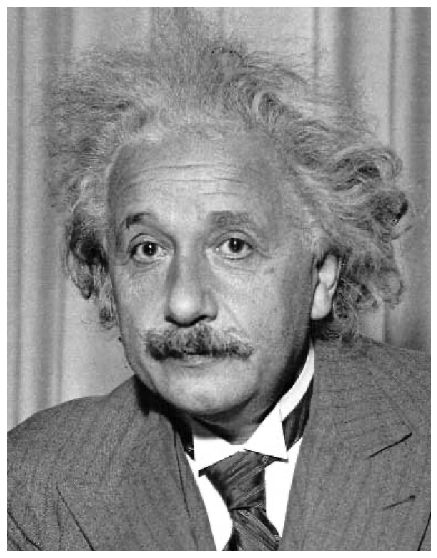

In [3]:
img_show(image,cmap=cm.gray)

Proviamo a vedere i vari passi del Canny Edge Detector. Il tutorial è ispirato da questa [guida](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123).

Per prima cosa applichiamo il filtro di blurring. 

In [4]:

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


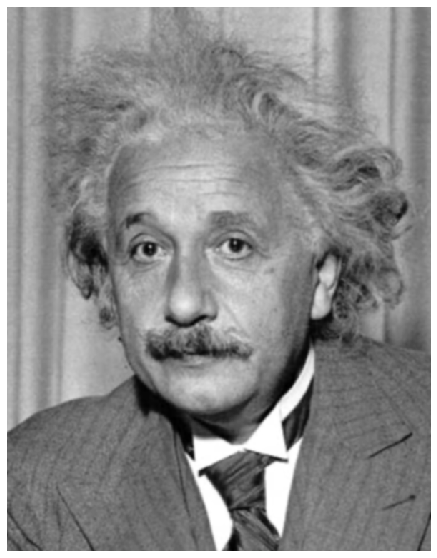

In [5]:
imageBlurred = convolve(image,gaussian_kernel(5,sigma=1.5))

img_show(imageBlurred,cmap=cm.gray)

Calcoliamo il gradiente (ampiezza e intensità)

In [6]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    
    G = np.sqrt(Ix**2 +  Iy**2)
    G = (G / G.max()*255).astype(np.uint8)
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [7]:
Mg, theta = sobel_filters(imageBlurred)

Il risultato tira fuori i bordi, ma possiamo notare che ci sono bordi spessi e bordi sottili. Inoltre l'intensità del gradiente varia troppo

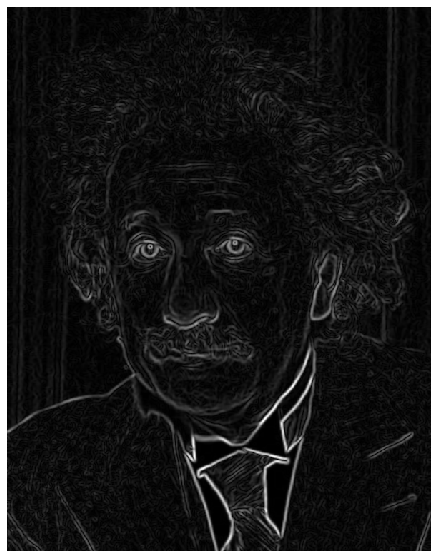

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [8]:

img_show(Mg,cmap=cm.gray)

np.unique(Mg)

Proviamo ad implementare la non-maximal suppression. Il principio è semplice: per ogni pixel, controlliamo la direzione del gradiente e prendiamo tutti i pixel lungo quella direzione. Le direzioni sono discretizzate lungo  i 4 quadranti $[-22.5,22.5]$, $[22.5,67.5]$, $[67.5,112.5]$ e $112.5, 157.5]$. 

In [9]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.uint8)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

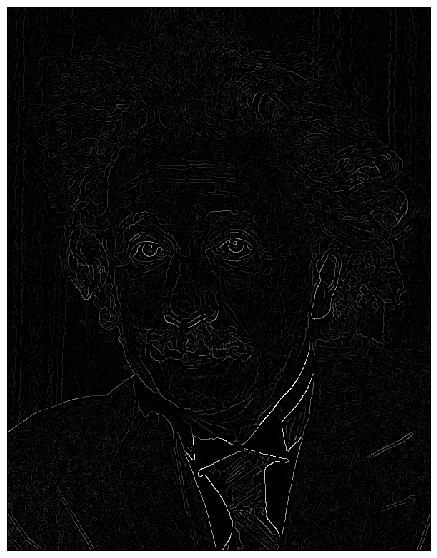

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
img = non_max_suppression(Mg,theta)

img_show(img,cmap=cm.gray)

np.unique(img)

Nell'immagine possiamo notare che i contorni si sono ristretti. Tuttavia, non abbiamo risolto il problema della variabilità d'intensità. Lo risolveremo con il double thresholding. 

In [11]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = np.max(img) * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
        
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)
    
    weak = np.uint8(72)
    strong = np.uint8(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

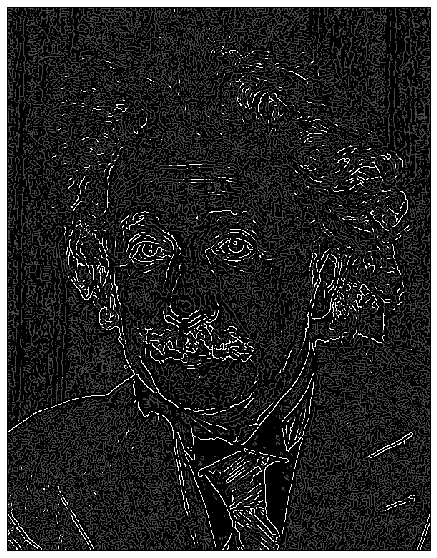

array([  0,  72, 255], dtype=uint8)

In [15]:
img2,weak,strong = threshold(img,0.05,0.15)

img_show(img2,cmap=cm.gray)

np.unique(img2)


L'immagine è molto confusa adesso, ma ha solo pixel weak e strong. Applichiamo l'isteresi: un pixel debole diventa bianco se è adiacente ad un bianco, altrimenti diventa nero. 

In [16]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

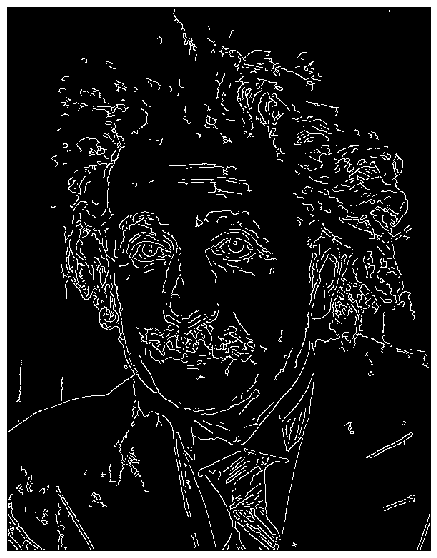

In [17]:
img3 = hysteresis(img2,weak,strong)

img_show(img3,cmap=cm.gray)

Mettiamo tutto insieme in un'unica funzione: 

In [18]:
def canny(img,lowThresholdRatio=0.05, highThresholdRatio=0.09, sigma=1.5):
    img = convolve(img,gaussian_kernel(5,sigma=sigma))
    G,theta = sobel_filters(img)
    
    img = non_max_suppression(G,theta)
    
    img,weak,low = threshold(img,lowThresholdRatio,highThresholdRatio)
    
    img = hysteresis(img,weak,low)
    
    return img

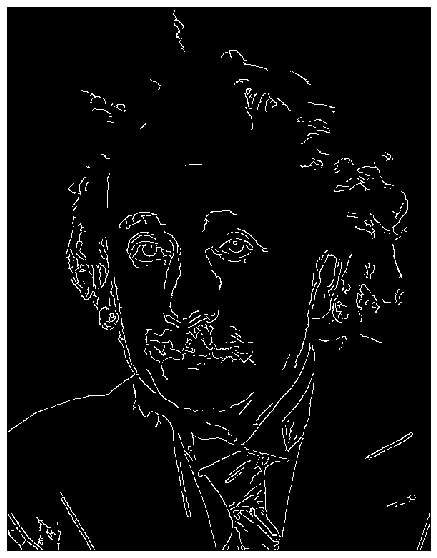

In [21]:
img_show(canny(image,lowThresholdRatio=0.1,highThresholdRatio=0.2,sigma=3),cmap=cm.gray)

## Giochiamo un po' con OpenCV 

In [22]:
import cv2
import numpy as np

# Our sketch generating function
def sketch(image):
    # Convert image to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Clean up image using Guassian Blur
    img_gray_blur = cv2.GaussianBlur(img_gray, (5,5), 0)
    
    # Extract edges
    canny_edges = cv2.Canny(img_gray_blur, 10, 70)
    
    # Do an invert binarize the image 
    ret, mask = cv2.threshold(canny_edges, 70, 255, cv2.THRESH_BINARY_INV)
    return mask


# Initialize webcam, cap is the object provided by VideoCapture
# It contains a boolean indicating if it was sucessful (ret)
# It also contains the images collected from the webcam (frame)
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    cv2.imshow('Our Live Sketcher', sketch(frame))
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
# Release camera and close windows
cap.release()
cv2.destroyAllWindows()      

# 2. Hough Transform

Proviamo ad applicare i concetti della Hough Transform. Proviamo a sviluppare un esempio realistico: l'individuazione delle linee di carreggiata lungo una strada. 

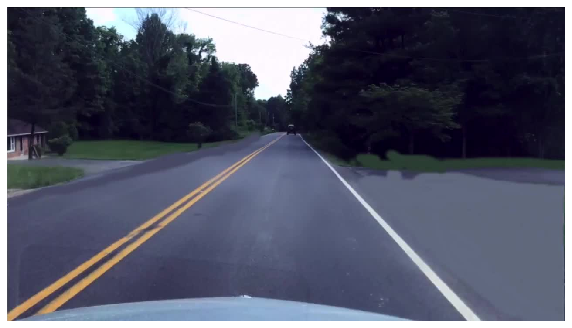

In [18]:
image = mp_image.imread(os.path.join(img_src,'lanes.png'))


img_show(image)

Vediamo come individuare le linee gialla e bianca lungo questa strada. 

Per prima cosa trasformiamo l'immagine in toni di grigio. 

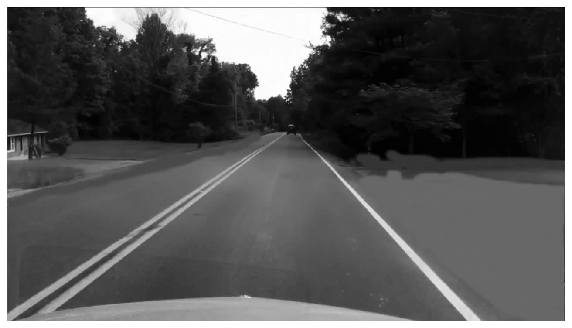

In [19]:
imageGray = rgb2gray(image)

img_show(imageGray,cmap=cm.gray)

Usiamo l'algoritmo di Canny per individuare i punti di interesse. 

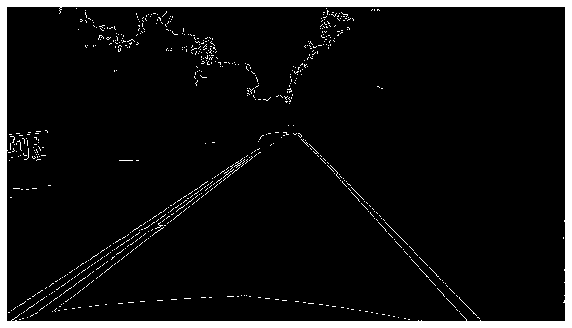

In [20]:
imgEdges = canny(imageGray,lowThresholdRatio=0.1,highThresholdRatio=0.2,sigma=3)

img_show(imgEdges,cmap=cm.gray)

Quante sono le linee? Cosa caratterizza questa immagine? Innanzitutto sappiamo che ogni punto è nero (intensità 0) o bianco (intensità 255)

In [21]:
np.unique(imgEdges)

array([  0, 255], dtype=uint8)

A questo punto possiamo impostare una versione semplice dell'algoritmo basato su Hough Transform, che construisce una griglia per ogni possibile valore di $\theta$ e $\rho$ e per ogni punto bianco nell'immagine aggiorna i contatori. Il codice è adattato da [qui](https://towardsdatascience.com/lines-detection-with-hough-transform-84020b3b1549). 

In [22]:
def line_detection(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
    detected_lines = set()
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    #
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    #
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    #
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    #
    accumulator = np.zeros((len(rhos), len(thetas)))
  #
    for y in range(edge_height):
        for x in range(edge_width):
            if edge_image[y][x] != 0:
                edge_point = [y - edge_height_half, x - edge_width_half]
                for theta_idx in range(len(thetas)):
                    rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                    theta = thetas[theta_idx]
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx][theta_idx] += 1
                    if accumulator[rho_idx][theta_idx] > t_count:
                        if (rho_idx,theta_idx) not in detected_lines: 
                            detected_lines.add((rho_idx,theta_idx))

    return accumulator, rhos, thetas, detected_lines

In [23]:
accumulator, rhos, thetas, detected_lines = line_detection(imageGray,imgEdges,t_count=1300)

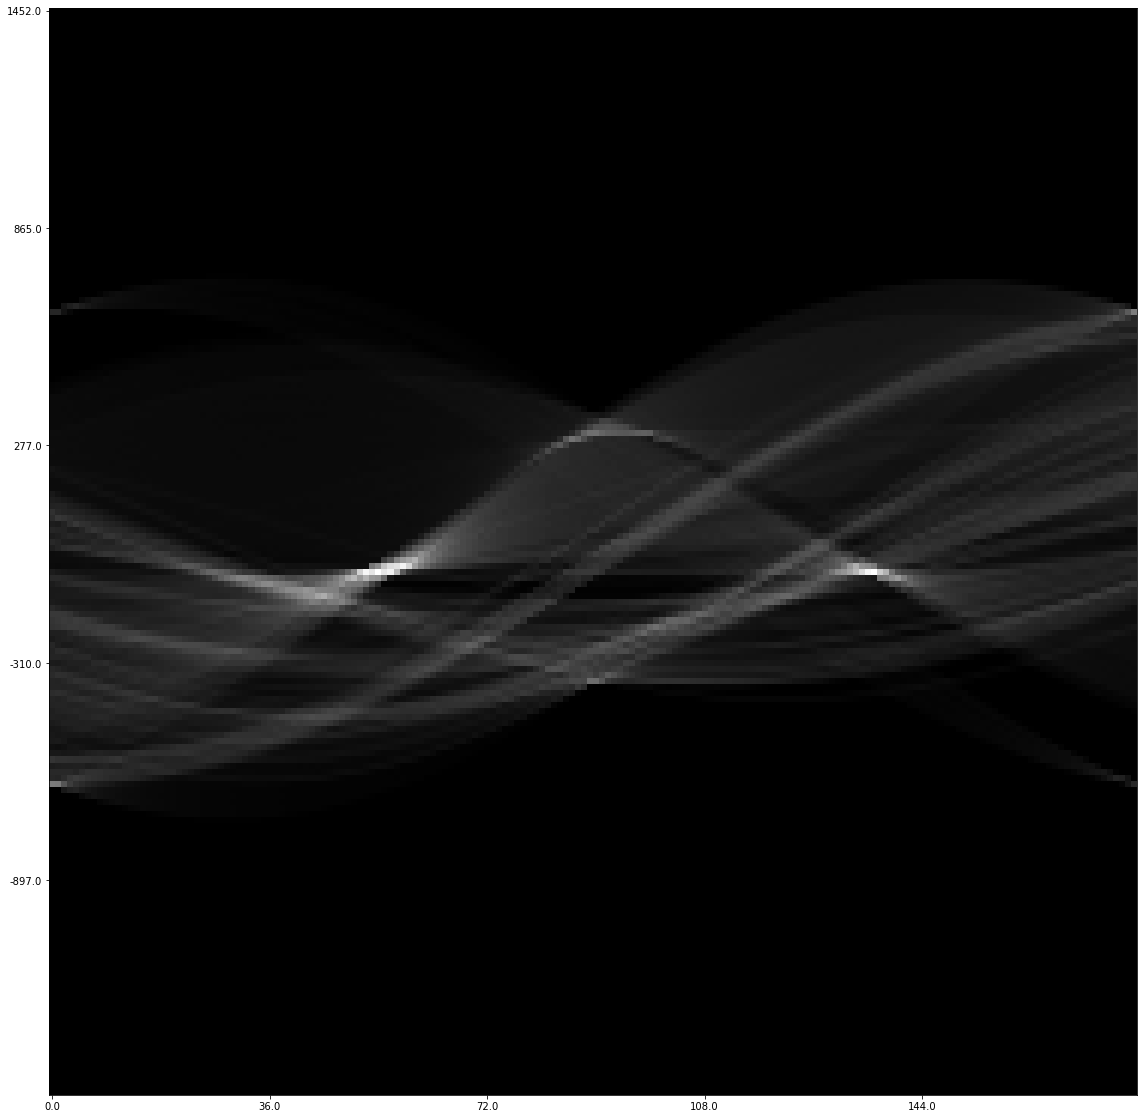

In [24]:
figure = plt.figure(figsize=(20, 20))

plt.imshow(np.flip(accumulator,0),cmap=cm.gray)

nx = accumulator.shape[0]
ny = accumulator.shape[1]
no_labels = 5 
step_x = int(nx / no_labels)
step_y = int(ny / no_labels) 
x_positions = np.arange(0,nx,step_x) 
y_positions = np.arange(0,ny,step_y) 
x_labels = thetas[::step_x] 
y_labels = np.round(rhos[::-1][::step_y]) 
plt.xticks(x_positions, x_labels)
plt.yticks(y_positions, y_labels)


plt.show()

Proviamo a plottare le linee nell'immagine originale

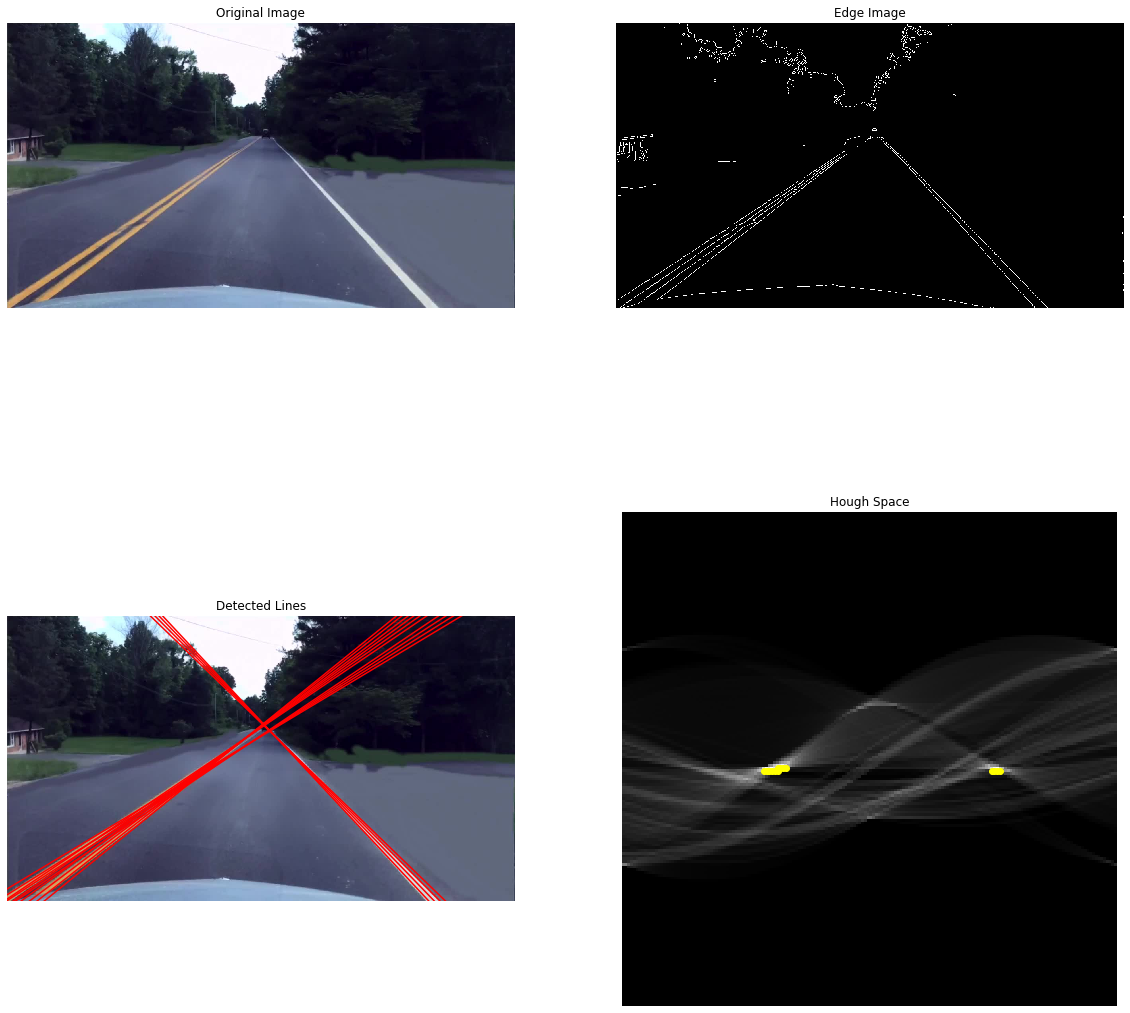

In [25]:
import matplotlib.lines as mlines

figure = plt.figure(figsize=(20, 20))
subplot1 = figure.add_subplot(2, 2, 1)
subplot1.imshow(image)
subplot1.axis("off")
subplot2 = figure.add_subplot(2, 2, 2)
subplot2.imshow(imgEdges, cmap="gray")
subplot2.axis("off")
subplot3 = figure.add_subplot(2, 2, 3)
subplot3.imshow(image)
subplot3.axis("off")
subplot4 = figure.add_subplot(2, 2, 4)
subplot4.imshow(np.flip(accumulator,0), cmap="gray")
subplot4.axis("off")
  #

edge_height_half, edge_width_half = imgEdges.shape[0]/2, imgEdges.shape[1]/2

for (rho_idx,theta_idx) in detected_lines:
    rho = rhos[rho_idx]
    theta = thetas[theta_idx]
    a = np.cos(np.deg2rad(theta))
    b = np.sin(np.deg2rad(theta))
    x0 = (a * rho) + edge_width_half
    y0 = (b * rho) + edge_height_half
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    subplot3.add_line(mlines.Line2D([x1, x2], [y1, y2],color="red"))
    subplot4.plot(theta_idx, accumulator.shape[1]-rho_idx, marker='o', color="yellow")


subplot1.title.set_text("Original Image")
subplot2.title.set_text("Edge Image")
subplot3.title.set_text("Detected Lines")
subplot4.title.set_text("Hough Space")
plt.show()

Ovviamente OpenCV ci aiuta semplificando il tutto con alcune funzioni predefinite: 

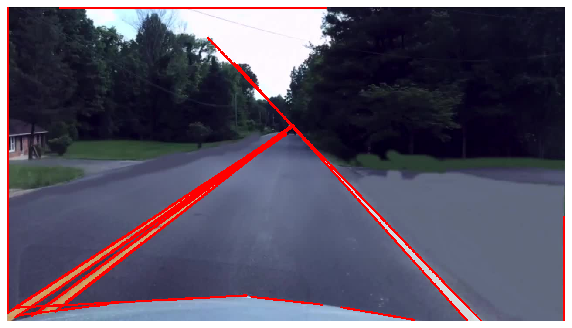

In [26]:
import cv2

imageToShow = (image*255).astype(np.uint8)

lines = cv2.HoughLinesP(imgEdges, 1, np.pi/180, 100, minLineLength=10, maxLineGap=250)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(imageToShow, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
img_show(imageToShow)